In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [2]:
import warnings
warnings.simplefilter("ignore", UserWarning)

import argparse
import os
import time
import shutil
import torch
import torchvision
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm
from torch.utils.data.sampler import SequentialSampler
from multiprocessing import cpu_count
from datetime import datetime

from models import TSN
from transforms import *
from opts import parser
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd

import datasets_video
import sys
import os
import easydict
import PIL
import glob

In [17]:
# empty GPU cache
torch.cuda.empty_cache()

best_prec1 = 0

# load correct custom dataset to work with pickle files
dataset = 'ngt'
fps_postfix = '_10fps'
if dataset == 'jester':
    num_classes = 27
    from dataset_custom import TSNDataSet
else:
    num_classes = 3846 # !!! THIS MIGHT CHANGE
    from dataset_custom import TSNDataSet

# Logs DataFrame
TRAIN_LOGS_DF = pd.DataFrame(columns=['epoch', 'train_loss', 'train_prec@1', 'train_prec@5', 'train_prec@100', 'train_prec@1000'])
VAL_LOGS_DF = pd.DataFrame(columns=['epoch', 'val_loss', 'val_prec@1', 'val_prec@5', 'val_prec@100', 'val_prec@1000'])

In [18]:
print(f'Python version: {sys.version}')
print(f'Torch version: {torch.__version__}')
print(f'Torchvision version: {torchvision.__version__}')
print(f'Pytroch Cuda Enabled: {torch.cuda.is_available()}')
# print GPU used
if torch.cuda.is_available():
    print(f'Pytorch CUDA version: {torch.version.cuda}')
    print(f'Pytroch Cuda Device Name: {torch.cuda.get_device_name(0)}')

Python version: 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
Torch version: 1.4.0
Torchvision version: 0.5.0
Pytroch Cuda Enabled: True
Pytorch CUDA version: 10.1
Pytroch Cuda Device Name: NVIDIA GeForce GTX 1060 with Max-Q Design


In [19]:
# Options
display(easydict.EasyDict(vars(parser.parse_known_args()[0])))

{'dataset': None,
 'modality': 'RGBFlow',
 'train_list': '',
 'val_list': '',
 'root_path': '',
 'store_name': '',
 'arch': 'BNInception',
 'num_segments': 4,
 'num_motion': 3,
 'consensus_type': 'avg',
 'k': 3,
 'dropout': 0.5,
 'loss_type': 'nll',
 'img_feature_dim': 256,
 'epochs': 45,
 'batch_size': 32,
 'lr': 0.001,
 'lr_steps': None,
 'momentum': 0.9,
 'weight_decay': 0.0005,
 'clip_gradient': 20,
 'no_partialbn': False,
 'print_freq': 10,
 'eval_freq': 1,
 'workers': 4,
 'resume': '',
 'evaluate': False,
 'snapshot_pref': '',
 'start_epoch': 0,
 'gpus': None,
 'flow_prefix': '',
 'root_log': 'log',
 'root_model': 'model',
 'root_output': 'output',
 'debug': False,
 'description': None,
 'optimizer': 'SGD',
 'input_size': 224,
 'dataset_subset': None,
 'fps': None}

In [20]:
def train(train_loader, model, criterion, optimizer, epoch, debug=False):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    top100 = AverageMeter()
    top1000 = AverageMeter()

    if args.no_partialbn:
        model.module.partialBN(False)
    else:
        model.module.partialBN(True)

    # switch to train mode
    model.train(epoch)

    end = time.time()
    for i, (input, target) in enumerate(tqdm(train_loader)):
        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda()
        input_var = Variable(input)
        target_var = Variable(target)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)
        
        if i is 0 and debug:
            print(f'output: {output.cpu().detach().numpy().shape}')
            print(f'loss: {loss}')
            print(f'loss: {loss}')
            
        # measure accuracy and record loss
        prec1, prec5, prec100, prec1000 = accuracy(output.data, target, topk=(1,5, 100, 1000))
        if i is 0 and debug:
            print(f'prec1: {prec1}, prec5: {prec5}, prec100: {prec100}, prec1000: {prec1000}')
        
        losses.update(loss, input.size(0))
        top1.update(prec1, input.size(0))
        top5.update(prec5, input.size(0))
        top100.update(prec100, input.size(0))
        top1000.update(prec1000, input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()

        if args.clip_gradient is not None:
            total_norm = clip_grad_norm(model.parameters(), args.clip_gradient)

        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

    sys.stdout.flush()
    print(
            'Train Epoch: [{0}/{1}][{2}/{3}], lr: {lr:.5f}\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
            'Prec@1 {top1.val:.2f} ({top1.avg:.2f})\tPrec@5 {top5.val:.2f} ({top5.avg:.2f})\t'
            'Prec@100 {top100.val:.2f} ({top100.avg:.2f})\tPrec@1000 {top1000.val:.2f} ({top1000.avg:.2f})'
        .format(
            epoch + 1, args.epochs, (i+1), len(train_loader),
            batch_time=batch_time, data_time=data_time,
            loss=losses, top1=top1, top5=top5, top100=top100, top1000=top1000, lr=optimizer.param_groups[-1]['lr']
        )
    )

    # Add to logs
    global TRAIN_LOGS_DF
    TRAIN_LOGS_DF = TRAIN_LOGS_DF.append({
        'epoch': epoch,
        'train_loss': losses.avg.cpu().detach().numpy(),
        'train_prec@1': top1.avg.cpu().detach().numpy(),
        'train_prec@5': top5.avg.cpu().detach().numpy(),
        'train_prec@100': top100.avg.cpu().detach().numpy(),
        'train_prec@1000': top1000.avg.cpu().detach().numpy(),
    }, ignore_index=True)

In [21]:
def validate(val_loader, model, criterion, iter, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    top100 = AverageMeter()
    top1000 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(tqdm(val_loader)):
        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda()
        with torch.no_grad():
            input_var = Variable(input)
            target_var = Variable(target)
            # compute output
            output = model(input_var)
            
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1, prec5, prec100, prec1000 = accuracy(output.data, target, topk=(1,5, 100, 1000))

        losses.update(loss, input.size(0))
        top1.update(prec1, input.size(0))
        top5.update(prec5, input.size(0))
        top100.update(prec100, input.size(0))
        top1000.update(prec1000, input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

    sys.stdout.flush()
    print(
            'Val Epoch: [{0}/{1}][{2}/{3}], \t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
            'Prec@1 {top1.val:.2f} ({top1.avg:.2f})\tPrec@5 {top5.val:.2f} ({top5.avg:.2f})\t'
            'Prec@100 {top100.val:.2f} ({top100.avg:.2f})\tPrec@1000 {top1000.val:.2f} ({top1000.avg:.2f})'
        .format(
            epoch + 1, args.epochs, (i+1), len(val_loader),
            batch_time=batch_time, data_time=batch_time,
            loss=losses, top1=top1, top5=top5, top100=top100, top1000=top1000,
        )
    )

        # Add to logs
    global VAL_LOGS_DF
    VAL_LOGS_DF = VAL_LOGS_DF.append({
        'epoch': epoch,
        'val_loss': losses.avg.cpu().detach().numpy(),
        'val_prec@1': top1.avg.cpu().detach().numpy(),
        'val_prec@5': top5.avg.cpu().detach().numpy(),
        'val_prec@100': top100.avg.cpu().detach().numpy(),
        'val_prec@1000': top1000.avg.cpu().detach().numpy(),
    }, ignore_index=True)

In [22]:
def print_info():
    print(f'Python version: {sys.version}')
    print(f'Torch version: {torch.__version__}')
    print(f'Torchvision version: {torchvision.__version__}')
    print(f'Pytroch Cuda Enabled: {torch.cuda.is_available()}')
    # print GPU used
    if torch.cuda.is_available():
        print(f'Pytorch CUDA version: {torch.version.cuda}')
        print(f'Pytorch Number of GPU\'s: {torch.cuda.device_count()}')
        for gpu_device_id in range(torch.cuda.device_count()):
            print(f'Pytroch Cuda Device {gpu_device_id} Name: {torch.cuda.get_device_name(gpu_device_id)}')
    
    # Options
    arguments = easydict.EasyDict(vars(parser.parse_known_args()[0]))
    print('----- PASSED ARGUMENTS -----')
    for key, value in arguments.items():
        print(f'{key}: {value}')

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, epoch, lr_steps):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    decay = 0.5 ** (sum(epoch >= np.array(lr_steps)))
    lr = args.lr * decay
    decay = args.weight_decay
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr * param_group['lr_mult']
        param_group['weight_decay'] = decay * param_group['decay_mult']


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    batch_size = target.size(0)
    _, pred = output.topk(num_classes, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def check_rootfolders():
    """Create log and model folder"""
    folders_util = [args.root_log, args.root_model, args.root_output]
    for folder in folders_util:
        if not os.path.exists(folder):
            print('creating folder ' + folder)
            os.mkdir(folder)

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    name = f'{args.dataset}_{args.description}_{datetime.now().strftime("%d-%m-%Y")}'
    torch.save(state, f'{args.root_model}/{name}_checkpoint.pth.tar')
    if is_best:
        shutil.copyfile(f'{args.root_model}/{name}_checkpoint.pth.tar', f'{args.root_model}/{name}_best.pth.tar')

In [23]:
def main(debug=False, resume=False):
    # empty cache
    torch.cuda.empty_cache()

    print_info() # print provided arguments
    global args, best_prec1
    
    # use arguments as dictionary with set functionality
    args = easydict.EasyDict(vars(parser.parse_known_args()[0]))

    # manually set training parameters
    args.gpus = list(range(torch.cuda.device_count()))
    args.n_frames = args.num_segments * (args.num_motion * 2 + 3)
    args.mffs_shape = (args.n_frames, args.input_size, args.input_size)
    args.workers = 0
    args.batch_size = 1
    
    # resume checkpoint
    if resume:
        args.evaluate = True
        args.resume = f'pretrained_models/MFF_jester_RGBFlow_BNInception_segment{args.num_segments}_3f1c_best.pth.tar'
        args.print_freq = 100
        args.batch_size = 20
        args.test_crops = 1
        args.num_segments = 4
        args.input_size = 224
        args.consensus_type = 'MLP'

    model = TSN(
        num_classes, args.num_segments, args.modality,
        base_model=args.arch,
        consensus_type=args.consensus_type,
        dropout=args.dropout, num_motion=args.num_motion,
        img_feature_dim=args.img_feature_dim,
        partial_bn=not args.no_partialbn,
        dataset=args.dataset
    )

    input_size = model.input_size
    crop_size = model.crop_size
    scale_size = model.scale_size
    input_rescale = model.rescale
    input_mean = model.input_mean
    input_std = model.input_std
    n_frames = args.num_motion * 2 + 3
    
    print(f'rescale: {input_rescale}, mean: {input_mean}, std: {input_std}')

    policies = model.get_optim_policies()
    model = torch.nn.DataParallel(model, device_ids=args.gpus).cuda()

    if args.resume:
        if os.path.isfile(args.resume):
            print(("=> loading checkpoint '{}'".format(args.resume)))
            checkpoint = torch.load(args.resume)
            args.start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            print(("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.evaluate, checkpoint['epoch'])))
        else:
            print(("=> no checkpoint found at '{}'".format(args.resume)))

    cudnn.benchmark = True

    if args.modality == 'RGB':
        data_length = 1
    elif args.modality in ['Flow', 'RGBDiff']:
        data_length = 5
    elif args.modality == 'RGBFlow':
        data_length = args.num_motion

    # VALIDATION DATASET
    print('Reading Validation Images')
    val_loader = torch.utils.data.DataLoader(
            TSNDataSet(
                f'{dataset}_4-MFFs-3f1c{fps_postfix}_train',
                args.mffs_shape,
                torchvision.transforms.Compose([
                    # Normalize according to ImageNet means and std
                    GroupNormalizeToTorch(input_rescale, input_mean, input_std, args.n_frames)
               ]),
               is_train=False, preload_pickles=False, debug=False, n=args.dataset_subset,
            ),
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.workers,
        pin_memory=False,
    )
    
    # define loss function (criterion) and optimizer
    if args.loss_type == 'nll':
        criterion = torch.nn.CrossEntropyLoss().cuda()
    else:
        raise ValueError("Unknown loss type")

    for group in policies:
        print(('group: {} has {} params, lr_mult: {}, decay_mult: {}'.format(
            group['name'], len(group['params']), group['lr_mult'], group['decay_mult'])))

    
    if args.optimizer == 'SGD':
        print(f'Using SGD Optimizer')
        optimizer = torch.optim.SGD(policies, args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
    elif args.optimizer == 'Adam':
        print('Using Adam Optimizer')
        optimizer = torch.optim.Adam(policies, args.lr, weight_decay=args.weight_decay)

    if args.evaluate:
        validate(val_loader, model, criterion, 0, 0)
        return
    
    # TRAINING DATASET
    print('Reading Training Images')
    train_loader = torch.utils.data.DataLoader(
                TSNDataSet(
                    f'{dataset}_4-MFFs-3f1c{fps_postfix}_train',
                    args.mffs_shape,
                    torchvision.transforms.Compose([
                         # Crop or Pad the image and resize to target size
                        CropPad(20, 224),
                        # Rotates the image 20 degrees
                        GroupMultiScaleRotate(20, (args.n_frames, args.input_size, args.input_size)),
                        # GridMask image masking
                        GridMask(224),
                        # Normalize according to ImageNet means and std
                        GroupNormalizeToTorch(input_rescale, input_mean, input_std, args.n_frames)
                   ])
                ),
            batch_size=args.batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=False,
        )
    
    return val_loader, train_loader
    
    print(f'TRAINING FOR {args.epochs} EPOCHS with BATCH SIZE {args.batch_size}')
    for epoch in range(args.start_epoch, args.epochs):
        adjust_learning_rate(optimizer, epoch, args.lr_steps)

        # train for one epoch
        train(train_loader, model, criterion, optimizer, epoch, debug=debug)

        # evaluate on validation set
        if (epoch + 1) % args.eval_freq == 0 or epoch == args.epochs - 1:
            prec1 = validate(val_loader, model, criterion, (epoch + 1) * len(train_loader), epoch)

            # remember best prec@1 and save checkpoint
            is_best = prec1 > best_prec1
            best_prec1 = max(prec1, best_prec1)
            save_checkpoint({
                'epoch': epoch + 1,
                'arch': args.arch,
                'state_dict': model.state_dict(),
                'best_prec1': best_prec1,
            }, is_best)

    # show and save logs
    print('----- TRAINING HISTORY LOGS -----')
    print(TRAIN_LOGS_DF)
    
    print('----- VALIDATION HISTORY LOGS -----')
    print(VAL_LOGS_DF)

    LOGS_DF = TRAIN_LOGS_DF.merge(VAL_LOGS_DF, how='inner', on='epoch')
    LOGS_DF.to_csv(f'output/{args.dataset}_{args.description}_{datetime.now().strftime("%d-%m-%Y_%I%p")}.csv', index=False)

In [24]:
if __name__ == '__main__':
    val_loader, train_loader = main(debug=False, resume=False)

Python version: 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
Torch version: 1.4.0
Torchvision version: 0.5.0
Pytroch Cuda Enabled: True
Pytorch CUDA version: 10.1
Pytorch Number of GPU's: 1
Pytroch Cuda Device 0 Name: NVIDIA GeForce GTX 1060 with Max-Q Design
----- PASSED ARGUMENTS -----
dataset: None
modality: RGBFlow
train_list: 
val_list: 
root_path: 
store_name: 
arch: BNInception
num_segments: 4
num_motion: 3
consensus_type: avg
k: 3
dropout: 0.5
loss_type: nll
img_feature_dim: 256
epochs: 45
batch_size: 32
lr: 0.001
lr_steps: None
momentum: 0.9
weight_decay: 0.0005
clip_gradient: 20
no_partialbn: False
print_freq: 10
eval_freq: 1
workers: 4
resume: 
evaluate: False
snapshot_pref: 
start_epoch: 0
gpus: None
flow_prefix: 
root_log: log
root_model: model
root_output: output
debug: False
description: None
optimizer: SGD
input_size: 224
dataset_subset: None
fps: None

    Initializing TSN with base model: BNInception.
    TSN Configurations:
        input_modalit

In [25]:
i_v = iter(val_loader)
i_t = iter(train_loader)

In [26]:
%%time
imgs, lbls = next(i_v)
print(f'mean: %.2f, min: %d, max: %d, dtype: %s, shape: %s' % (imgs.mean(), imgs.min(), imgs.max(), imgs.dtype, imgs.shape))

mean: 33.60, min: -128, max: 151, dtype: torch.float32, shape: torch.Size([1, 36, 224, 224])
Wall time: 78.5 ms


In [27]:
lbls

tensor([0])

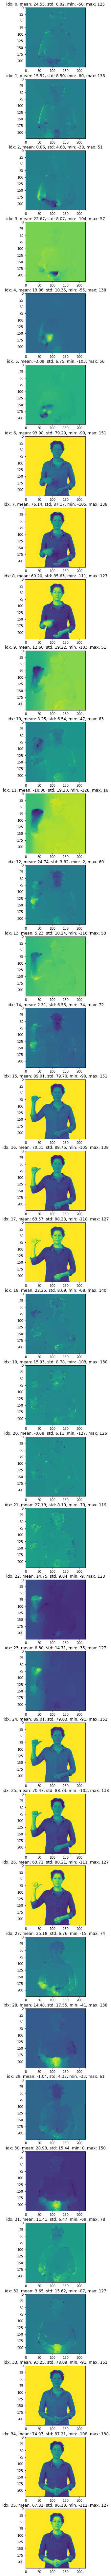

In [28]:
imgs_np = imgs.numpy()[0]
fig, axes = plt.subplots(36, 1, figsize=(6,144))
offset = 0

for idx, i in enumerate(imgs_np):
    img = imgs_np[idx]
    img_stats = (idx, img.mean(), img.std(), img.min(), img.max())
    axes[idx].set_title(f'idx: %s, mean: %.2f, std: %.2f, min: %d, max: %d' % img_stats, size=12)
    axes[idx].imshow(img)

plt.show()

In [15]:
# def get_size(obj, seen=None, recursive_call=True):
#     """Recursively finds size of objects"""
#     size = sys.getsizeof(obj)
#     if seen is None:
#         seen = set()
#     obj_id = id(obj)
#     if obj_id in seen:
#         return 0
#     # Important mark as seen *before* entering recursion to gracefully handle
#     # self-referential objects
#     seen.add(obj_id)
#     if isinstance(obj, dict):
#         size += sum([get_size(v, seen) for v in obj.values()])
#         size += sum([get_size(k, seen) for k in obj.keys()])
#     elif hasattr(obj, '__dict__'):
#         size += get_size(obj.__dict__, seen)
#     elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
#         size += sum([get_size(i, seen) for i in obj])
    
#     if not recursive_call:
#         if size > 2**20:
#             print(f'Object is %.2fMB' % (size / 2**20))
#         elif size > 2**10:
#             print(f'Object is %.2fKB' % (size / 2**10))
#         else:
#             print(f'Object is %.2fB' % size)
        
#     return size

# get_size(pickle_subset, recursive_call=False)